# Setting up the environment

## Importing required libraries:
Required libraries include:
<ul>
    <li><strong>Numpy</strong> and <strong>Pandas</strong> for data analysis</li>
    <li><strong>Matplotlib</strong> and <strong>Seaborn</strong> for data visualization</li>
</ul>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML algorithm metrics and measurements:
import sklearn.metrics as metrics

# Logistic regression:
from sklearn.linear_model import LogisticRegression

# Logistic regression CV:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold

# Bernoulli Naive Bayes Classifier:
from sklearn.naive_bayes import BernoulliNB

# Random Forest:
from sklearn.ensemble import RandomForestClassifier

# Classifiers
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

# Ada Boost classifier
from sklearn.ensemble import AdaBoostClassifier

# XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

# Cross validation
from sklearn.model_selection import cross_validate

%matplotlib inline

## Loading the data
<p>
The dataset was acquired from <a href="https://www.kaggle.com/datasets/arashnic/covid19-case-surveillance-public-use-dataset">Kaggle</a> and it contains the data for covid patients in the US.
</p>
<p>
In order to avoid warning about mixed types, the first three columns need to be parsed as datetime during loading.
</p>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
df = pd.read_csv("./MyDrive/Datasets/covid/covid.csv", parse_dates=[0, 1, 2])

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


# Data Analysis

## Exploring the dataset
The following section explores the dataset's properties:
<ul>
  <li>Overview of data</li>
  <li>Shape and size</li>
  <li>Features</li>
</ul>

In [ ]:
df.head(10)

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn
0,2020-11-10,2020-11-10,NaT,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,Unknown,No,No
1,2020-11-14,2020-11-10,2020-11-10,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No
2,2020-11-19,2020-11-10,2020-11-09,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No
3,2020-11-14,2020-11-10,NaT,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",Missing,Missing,No,Missing
4,2020-11-13,2020-11-10,2020-11-10,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,Yes
5,2020-11-17,2020-11-10,2020-11-08,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",Missing,Missing,Missing,Missing
6,2020-11-14,2020-11-10,NaT,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,Missing,Missing,Missing
7,2020-11-10,2020-11-10,NaT,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",Missing,Missing,Missing,Missing
8,2020-11-10,2020-11-10,NaT,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",Unknown,Unknown,No,Unknown
9,2020-11-17,2020-11-10,NaT,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",Missing,Missing,Missing,Missing


In [ ]:
no_of_instances, no_of_features = df.shape
print("The dataset containes %d features and %d instances."
      %(no_of_features, no_of_instances))

The dataset containes 11 features and 8405079 instances.


In [ ]:
df.dtypes

cdc_report_dt                    datetime64[ns]
pos_spec_dt                      datetime64[ns]
onset_dt                         datetime64[ns]
current_status                           object
sex                                      object
age_group                                object
Race and ethnicity (combined)            object
hosp_yn                                  object
icu_yn                                   object
death_yn                                 object
medcond_yn                               object
dtype: object

## Data cleanse

### Splitting "Race and ethnicity (combined)" column

In [ ]:
race_ethnicity_split = df['Race and ethnicity (combined)'].str.split(",",n=1,expand=True)
df["race"] = race_ethnicity_split[0]
df["ethnicity"] = race_ethnicity_split[1]

df = df.drop(["Race and ethnicity (combined)"], axis=1)

df.columns

Index(['cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'current_status', 'sex',
       'age_group', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn', 'race',
       'ethnicity'],
      dtype='object')

### Dropping unused features

"current_status", and "date" features are not used in our model; so the following can be removed from the data frame:
<ul>
  <li>cdc_report_dt</li>
  <li>pos_spec_dt</li>
  <li>ondet_dt</li>
</ul>


In [ ]:
df = df.drop(["cdc_report_dt",
              "pos_spec_dt",
              "onset_dt",
              "current_status"], axis=1)

df.columns

Index(['sex', 'age_group', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn',
       'race', 'ethnicity'],
      dtype='object')

### Dealing with missing values

The below counts the number of NULL values in each feature.

In [ ]:
df.isnull().sum()

sex                18
age_group          89
hosp_yn             0
icu_yn              0
death_yn            0
medcond_yn          0
race                7
ethnicity     4578441
dtype: int64

#### ethnicity
"ethnicity" containes mostly missing data and the non-Null data are all the same value (unique), so the approach would be to remove this feature:

In [ ]:
df["ethnicity"].value_counts()

 Non-Hispanic    3826638
Name: ethnicity, dtype: int64

In [ ]:
df = df.drop(["ethnicity"], axis=1)

#### age_group, race, and sex

As seen below (empty resultset), the instances with missing "age_group" data also contain the instances with missing "sex" and "race".

In [ ]:
df[(df["sex"].isnull() | df["race"].isnull()) & (~df["age_group"].isnull())].shape[0]

0

the best approach is to completely remove them from the data frame:

In [ ]:
df = df[~df['age_group'].isnull()]
df.isnull().sum()

sex           0
age_group     0
hosp_yn       0
icu_yn        0
death_yn      0
medcond_yn    0
race          0
dtype: int64

### Cleaning up the target feature

The target feature "death_yn" will be stating whether the patient has died from COVID or not; however, currently it contains other extra and unclear values as well:

In [ ]:
df.death_yn.value_counts()

No         3690765
Missing    3486890
Unknown    1043765
Yes         183570
Name: death_yn, dtype: int64

In order to deal with unclear values, the instances containing "Unknown" and "Missing" for their "death_yn" feature will be removed from the data frame:

In [ ]:
df = df[~df['death_yn'].isin(['Unknown', 'Missing'])]

df.death_yn.value_counts()

No     3690765
Yes     183570
Name: death_yn, dtype: int64

### Converting categorial string features into nominal
This step is needed in order to present the correlation matrix

#### death_yn

In [ ]:
df['death_yn'].replace(['No', 'Yes'],
                        [0, 1], inplace=True)

df['death_yn'].value_counts()

0    3690765
1     183570
Name: death_yn, dtype: int64

#### medcond_yn

In [ ]:
df["medcond_yn"].value_counts()

Missing    2362102
No          565617
Yes         559721
Unknown     386895
Name: medcond_yn, dtype: int64

In [ ]:
df['medcond_yn'].replace(['Missing', 'No', 'Yes', 'Unknown'],
                        [0, 1, 2, 0], inplace=True)

df['medcond_yn'].value_counts()

0    2748997
1     565617
2     559721
Name: medcond_yn, dtype: int64

#### sex

In [ ]:
df["sex"].value_counts()

Female     2031674
Male       1822491
Unknown      13674
Missing       6387
Other          109
Name: sex, dtype: int64

In [ ]:
df['sex'].replace(['Female', 'Male', 'Unknown', 'Missing', "Other"],
                        [1, 2, 0, 0, 3], inplace=True)

df['sex'].value_counts()

1    2031674
2    1822491
0      20061
3        109
Name: sex, dtype: int64

#### hosp_yn

In [ ]:
df["hosp_yn"].value_counts()

No         2696149
Unknown     405513
Missing     391361
Yes         381312
Name: hosp_yn, dtype: int64

In [ ]:
df['hosp_yn'].replace(['No', 'Yes', 'Unknown', 'Missing'],
                        [1, 2, 0, 0], inplace=True)

df['hosp_yn'].value_counts()

1    2696149
0     796874
2     381312
Name: hosp_yn, dtype: int64

#### icu_yn

In [ ]:
df["icu_yn"].value_counts()

Missing    2441745
Unknown     699353
No          686441
Yes          46796
Name: icu_yn, dtype: int64

In [ ]:
df['icu_yn'].replace(['No', 'Yes', 'Unknown', 'Missing'],
                        [1, 2, 0, 0], inplace=True)

df['icu_yn'].value_counts()

0    3141098
1     686441
2      46796
Name: icu_yn, dtype: int64

#### age_group

In [ ]:
df['age_group'].value_counts()

20 - 29 Years    728676
30 - 39 Years    617068
40 - 49 Years    573413
50 - 59 Years    555579
60 - 69 Years    401745
10 - 19 Years    393697
70 - 79 Years    241759
80+ Years        211305
0 - 9 Years      146754
Unknown            4339
Name: age_group, dtype: int64

In [ ]:
df['age_group'].replace([
    '0 - 9 Years', 
    '10 - 19 Years',
    '20 - 29 Years',
    '30 - 39 Years',
    '40 - 49 Years',
    '50 - 59 Years',
    '60 - 69 Years',
    '70 - 79 Years',
    '80+ Years',
    'Unknown'
    ],
    range(10), inplace=True)

df['age_group'].value_counts()

2    728676
3    617068
4    573413
5    555579
6    401745
1    393697
7    241759
8    211305
0    146754
9      4339
Name: age_group, dtype: int64

#### race

In [ ]:
df['race'].value_counts()

White                                     1449748
Unknown                                    997563
Hispanic/Latino                            599219
Black                                      400079
Missing                                    160688
Multiple/Other                             152141
Asian                                       84137
American Indian/Alaska Native               20524
Native Hawaiian/Other Pacific Islander      10236
Name: race, dtype: int64

In [ ]:
df['race'].replace([
    'Unknown', 
    'Missing',
    'Multiple/Other',
    'White',
    'Hispanic/Latino',
    'Black',
    'Asian',
    'American Indian/Alaska Native',
    'Native Hawaiian/Other Pacific Islander',
    ],
    [0, 0, 0, 1, 2, 3, 4, 5, 6], inplace=True)

df['race'].value_counts()

1    1449748
0    1310392
2     599219
3     400079
4      84137
5      20524
6      10236
Name: race, dtype: int64

### The final shape of the DF

In [ ]:
df.shape

(3874335, 7)

In [ ]:
df.dtypes

sex           int64
age_group     int64
hosp_yn       int64
icu_yn        int64
death_yn      int64
medcond_yn    int64
race          int64
dtype: object

## Correlation Matrix
The following displays the correlation matrix containing all the numeric variables.

In [ ]:
df.corr() \
    .style.background_gradient(cmap='coolwarm') \
    .format(precision = 2)

,sex,age_group,hosp_yn,icu_yn,death_yn,medcond_yn,race
sex,1.00,-0.01,0.02,0.01,0.03,-0.00,-0.01
age_group,-0.01,1.00,0.18,0.05,0.34,0.13,-0.01
hosp_yn,0.02,0.18,1.00,0.28,0.20,0.15,0.14
icu_yn,0.01,0.05,0.28,1.00,0.09,0.47,0.08
death_yn,0.03,0.34,0.20,0.09,1.00,0.10,0.05
medcond_yn,-0.00,0.13,0.15,0.47,0.10,1.00,0.13
race,-0.01,-0.01,0.14,0.08,0.05,0.13,1.00


# Machine Learning
This section implements several Machine Learning algorithms

## Preparations

### Splitting the data into training and testing subsets

In [ ]:
# Splitting the dataset into features and results
x=df.drop("death_yn",axis=1)
y=df["death_yn"]

In [ ]:
np.random.seed(42)

from sklearn.model_selection import train_test_split, cross_val_score
x_train ,x_test,y_train,y_test = train_test_split(x,y,stratify=y,random_state=12,test_size = 0.025, train_size=0.1)

### Defining helper functions

#### Preparing the comparison table

In [ ]:
columns = ['Model','accuracy score', ' Precision','Recall','f1_score']
evaluation_df = pd.DataFrame(columns=columns)

#### Drawing the confusion matrix

In [ ]:
def Plot_confusion_matrix(y, pred, model_name):
    cm = metrics.confusion_matrix(y, pred)
    plt.clf()
    plt.imshow(cm, cmap=plt.cm.Accent)
    categoryNames = ['Survival','Death']
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    ticks = np.arange(len(categoryNames))
    plt.xticks(ticks, categoryNames, rotation=45)
    plt.yticks(ticks, categoryNames)
    s = [['TN','FP'], ['FN', 'TP']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
    plt.show()

#### Plotting ROC

In [ ]:
def Plot_roc_curve(y, y_prob, model_name):
    plt.title(f'ROC Curve - {model_name}')
    fpr, tpr, thresholds = metrics.roc_curve(y, y_prob)
    plt.plot(fpr,tpr,label="Test, auc="+str(metrics.roc_auc_score(y, y_prob)))
    plt.legend(loc=4)
    plt.show()

#### Displaying metrics

In [ ]:
def print_results(model_name, y_test, y_pred, pred_prob=None):
    print(model_name)
    print('--------------------------------------------------------------------------')
 
    precision_score = metrics.precision_score(y_test, y_pred)
    recall_score = metrics.recall_score(y_test, y_pred)
    
    accuracy_score  = metrics.accuracy_score(y_test,y_pred)
    print(f'accuracy score :{accuracy_score}') 

    f1_score = metrics.f1_score(y_test,y_pred)
    
    classification_report = metrics.classification_report(y_test,y_pred)
    print(classification_report)
    
#   save scores into dataframe for comparison
    evaluation_df.loc[len(evaluation_df.index)] = [model_name,accuracy_score,precision_score,recall_score, f1_score]
    
    Plot_confusion_matrix(y_test,y_pred,model_name)
    
    if pred_prob is not None:
        Plot_roc_curve(y_test,pred_prob,model_name)


## ML Algorithms

### Logistic regression

Logistic Regression
--------------------------------------------------------------------------
accuracy score :0.9551616266944735
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     92270
           1       0.58      0.20      0.29      4589

    accuracy                           0.96     96859
   macro avg       0.77      0.59      0.64     96859
weighted avg       0.94      0.96      0.94     96859



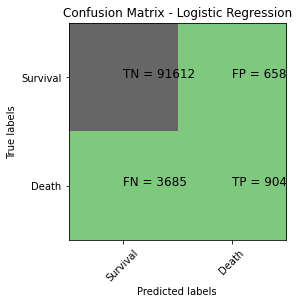

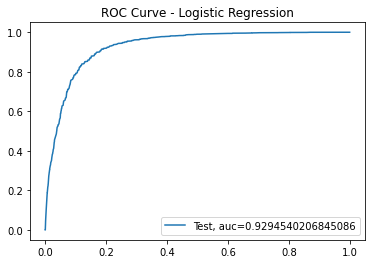

,Model,accuracy score,Precision,Recall,f1_score
0,Logistic Regression,0.955162,0.578745,0.196993,0.293936


In [ ]:
lr_model = LogisticRegression(max_iter=200,random_state=12)
lr_model.fit(x_train,y_train)
pred1 = lr_model.predict(x_test)
prob1 = lr_model.predict_proba(x_test)
print_results("Logistic Regression", y_test, pred1,prob1[:,-1])

evaluation_df

### Logistic regression CV

Logistic Regression CV
--------------------------------------------------------------------------
accuracy score :0.9551616266944735
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     92270
           1       0.58      0.20      0.29      4589

    accuracy                           0.96     96859
   macro avg       0.77      0.59      0.64     96859
weighted avg       0.94      0.96      0.94     96859



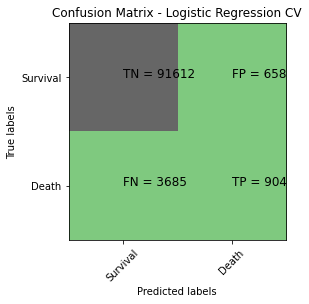

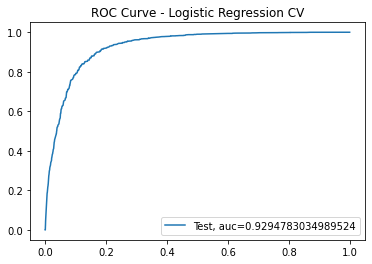

,Model,accuracy score,Precision,Recall,f1_score
0,Logistic Regression,0.955162,0.578745,0.196993,0.293936
1,Logistic Regression CV,0.955162,0.578745,0.196993,0.293936


In [ ]:
cv_num = KFold(n_splits=10, shuffle=True, random_state=12)
lr_modelCV = LogisticRegressionCV(max_iter=200,penalty='l2',
                                  scoring='roc_auc',cv=cv_num,
                                  tol=10,random_state=12)
lr_modelCV.fit(x_train,y_train)
pred2 = lr_modelCV.predict(x_test)
prob2 = lr_modelCV.predict_proba(x_test)
print_results("Logistic Regression CV", y_test, pred2,prob2[:,-1])

evaluation_df

### Bernoulli Naive Bayes

Bernoulli Naive Bayes
--------------------------------------------------------------------------
accuracy score :0.9526218523833614


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.95      1.00      0.98     92270
           1       0.00      0.00      0.00      4589

    accuracy                           0.95     96859
   macro avg       0.48      0.50      0.49     96859
weighted avg       0.91      0.95      0.93     96859



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


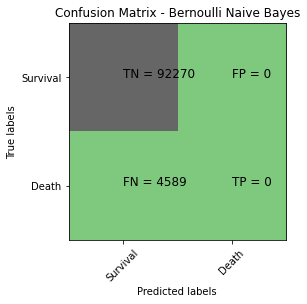

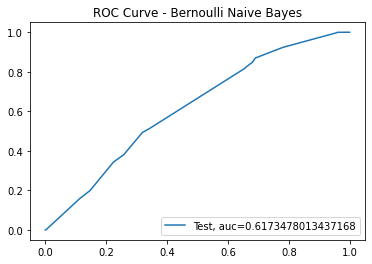

,Model,accuracy score,Precision,Recall,f1_score
0,Logistic Regression,0.955162,0.578745,0.196993,0.293936
1,Logistic Regression CV,0.955162,0.578745,0.196993,0.293936
2,Bernoulli Naive Bayes,0.952622,0.000000,0.000000,0.000000


In [ ]:
gnb_model = BernoulliNB()
gnb_model.fit(x_train,y_train)
pred3 = gnb_model.predict(x_test)
prob3 = gnb_model.predict_proba(x_test)
print_results("Bernoulli Naive Bayes", y_test, pred3,prob3[:,-1])

evaluation_df

### Random forest + gini

Random Forest Classifier + gini
--------------------------------------------------------------------------
accuracy score :0.9582589124397319
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     92270
           1       0.60      0.35      0.44      4589

    accuracy                           0.96     96859
   macro avg       0.79      0.67      0.71     96859
weighted avg       0.95      0.96      0.95     96859



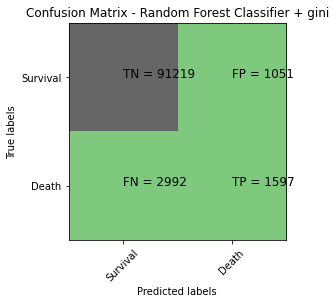

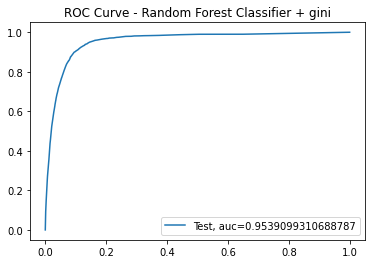

,Model,accuracy score,Precision,Recall,f1_score
0,Logistic Regression,0.955162,0.578745,0.196993,0.293936
1,Logistic Regression CV,0.955162,0.578745,0.196993,0.293936
2,Bernoulli Naive Bayes,0.952622,0.000000,0.000000,0.000000
3,Random Forest Classifier + gini,0.958259,0.603097,0.348006,0.441343


In [ ]:
rfc_model = RandomForestClassifier(bootstrap = True,
                                max_features = 'sqrt', random_state=12)
rfc_model.fit(x_train,y_train)
pred4 = rfc_model.predict(x_test)
prob4 = rfc_model.predict_proba(x_test)
print_results("Random Forest Classifier + gini", y_test, pred4,prob4[:,-1])

evaluation_df

### Random forest + entropy

Random Forest Classifier + entropy 
--------------------------------------------------------------------------
accuracy score :0.9582898852971846
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     92270
           1       0.60      0.35      0.44      4589

    accuracy                           0.96     96859
   macro avg       0.79      0.67      0.71     96859
weighted avg       0.95      0.96      0.95     96859



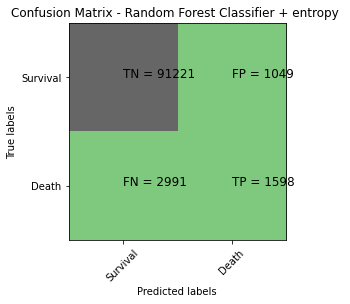

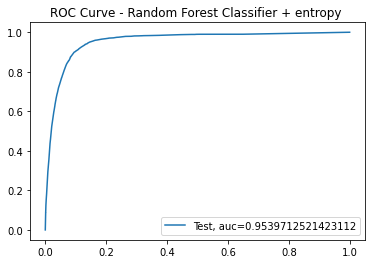

,Model,accuracy score,Precision,Recall,f1_score
0,Random Forest Classifier + entropy,0.95829,0.603702,0.348224,0.44168


In [ ]:
rfc_model2 = RandomForestClassifier(bootstrap = True,criterion='entropy',
                                    max_features = 'sqrt', random_state=12)
rfc_model2.fit(x_train,y_train)
pred5 = rfc_model2.predict(x_test)
prob5 = rfc_model2.predict_proba(x_test)
print_results("Random Forest Classifier + entropy ", y_test, pred5,prob5[:,-1])

evaluation_df

### Bagging classifier

Bagging Classifier
--------------------------------------------------------------------------
accuracy score :0.9565141081365697
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     92270
           1       0.73      0.13      0.22      4589

    accuracy                           0.96     96859
   macro avg       0.85      0.56      0.60     96859
weighted avg       0.95      0.96      0.94     96859



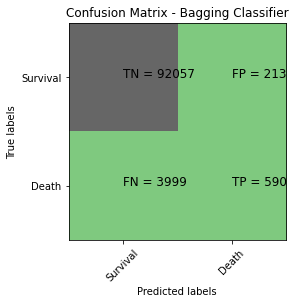

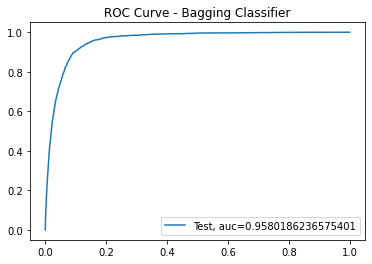

,Model,accuracy score,Precision,Recall,f1_score
0,Logistic Regression,0.955162,0.578745,0.196993,0.293936
1,Logistic Regression CV,0.955162,0.578745,0.196993,0.293936
2,Bernoulli Naive Bayes,0.952622,0.000000,0.000000,0.000000
3,Random Forest Classifier + gini,0.958259,0.603097,0.348006,0.441343
4,Random Forest Classifier + entropy,0.958290,0.603702,0.348224,0.441680
5,Bagging Classifier,0.956514,0.734745,0.128568,0.218843


In [ ]:
bcf_model = BaggingClassifier(DecisionTreeClassifier(),
                              n_estimators=200,
                              max_samples=0.8,
                              max_features=0.8,
                              oob_score=True,
                              random_state=12)
bcf_model.fit(x_train,y_train)
pred6 = bcf_model.predict(x_test)
prob6 = bcf_model.predict_proba(x_test)
print_results("Bagging Classifier", y_test, pred6,prob6[:,-1])

evaluation_df

### Gradient Boosting classifier

Gradient Boosting Classifier
--------------------------------------------------------------------------
accuracy score :0.9590538824476816
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     92270
           1       0.62      0.35      0.45      4589

    accuracy                           0.96     96859
   macro avg       0.79      0.67      0.71     96859
weighted avg       0.95      0.96      0.95     96859



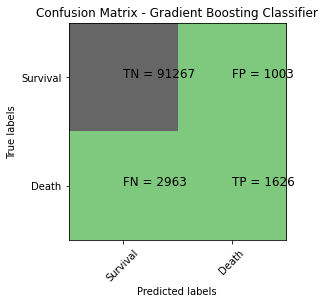

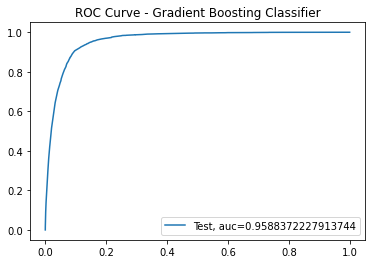

,Model,accuracy score,Precision,Recall,f1_score
0,Logistic Regression,0.955162,0.578745,0.196993,0.293936
1,Logistic Regression CV,0.955162,0.578745,0.196993,0.293936
2,Bernoulli Naive Bayes,0.952622,0.000000,0.000000,0.000000
3,Random Forest Classifier + gini,0.958259,0.603097,0.348006,0.441343
4,Random Forest Classifier + entropy,0.958290,0.603702,0.348224,0.441680
5,Bagging Classifier,0.956514,0.734745,0.128568,0.218843
6,Gradient Boosting Classifier,0.959054,0.618486,0.354326,0.450540


In [ ]:
gbc_model = GradientBoostingClassifier()
gbc_model.fit(x_train,y_train)
pred7 = gbc_model.predict(x_test)
prob7 = gbc_model.predict_proba(x_test)
print_results("Gradient Boosting Classifier", y_test, pred7,prob7[:,-1])

evaluation_df

### AdaBoost classifier

Ada Boost Classifier
--------------------------------------------------------------------------
accuracy score :0.9579388595793886
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     92270
           1       0.59      0.37      0.46      4589

    accuracy                           0.96     96859
   macro avg       0.78      0.68      0.72     96859
weighted avg       0.95      0.96      0.95     96859



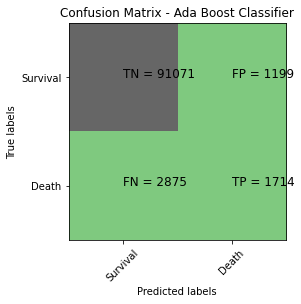

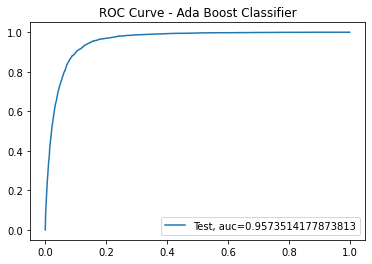

,Model,accuracy score,Precision,Recall,f1_score
0,Logistic Regression,0.955162,0.578745,0.196993,0.293936
1,Logistic Regression CV,0.955162,0.578745,0.196993,0.293936
2,Bernoulli Naive Bayes,0.952622,0.000000,0.000000,0.000000
3,Random Forest Classifier + gini,0.958259,0.603097,0.348006,0.441343
4,Random Forest Classifier + entropy,0.958290,0.603702,0.348224,0.441680
5,Bagging Classifier,0.956514,0.734745,0.128568,0.218843
6,Gradient Boosting Classifier,0.959054,0.618486,0.354326,0.450540
7,Ada Boost Classifier,0.957939,0.588397,0.373502,0.456945


In [ ]:
adb_model = AdaBoostClassifier(n_estimators=200, random_state=12)
adb_model.fit(x_train,y_train)
pred8 = adb_model.predict(x_test)
prob8 = adb_model.predict_proba(x_test)

print_results("Ada Boost Classifier", y_test, pred8,prob8[:,-1])

evaluation_df

### XGBoost classifier

XG Boosting Classifier
--------------------------------------------------------------------------
accuracy score :0.9590538824476816
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     92270
           1       0.62      0.35      0.45      4589

    accuracy                           0.96     96859
   macro avg       0.79      0.67      0.71     96859
weighted avg       0.95      0.96      0.95     96859



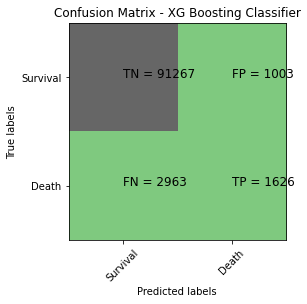

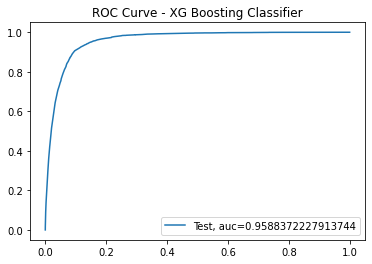

,Model,accuracy score,Precision,Recall,f1_score
0,Logistic Regression,0.955162,0.578745,0.196993,0.293936
1,Logistic Regression CV,0.955162,0.578745,0.196993,0.293936
2,Bernoulli Naive Bayes,0.952622,0.000000,0.000000,0.000000
3,Random Forest Classifier + gini,0.958259,0.603097,0.348006,0.441343
4,Random Forest Classifier + entropy,0.958290,0.603702,0.348224,0.441680
5,Bagging Classifier,0.956514,0.734745,0.128568,0.218843
6,Gradient Boosting Classifier,0.959054,0.618486,0.354326,0.450540
7,Ada Boost Classifier,0.957939,0.588397,0.373502,0.456945
8,XG Boosting Classifier,0.959054,0.618486,0.354326,0.450540


In [ ]:
cv = KFold(n_splits=10, random_state=12, shuffle=True)
model = XGBClassifier(cv=cv,learning_rate=0.01)

gbc_model.fit(x_train,y_train)
pred9 = gbc_model.predict(x_test)
prob9 = gbc_model.predict_proba(x_test)
print_results("XG Boosting Classifier", y_test, pred9, prob9[:,-1])

evaluation_df

## Cross validation and Overfit analysis

In [ ]:
rf_model = RandomForestClassifier(bootstrap = True,
                                  criterion='entropy',
                                  verbose=1,
                                  oob_score=True,
                                  max_features = 'sqrt',
                                  random_state=12)

cross_validation_result = cross_validate(rf_model,
                                         x_train, y_train,
                                         return_train_score=True)

cross_validation_result

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   18.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   15.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

{'fit_time': array([22.13838768, 20.15164065, 21.71949697, 23.71771669, 22.07231259]),
 'score_time': array([1.14004064, 1.15001059, 1.24937487, 1.16482997, 1.2356813 ]),
 'test_score': array([0.95839302, 0.96023849, 0.95916734, 0.95863769, 0.95806984]),
 'train_score': array([0.96025759, 0.95982849, 0.96008014, 0.96013835, 0.9603771 ])}

## Threshold tweaking

In [ ]:
def performRfUsingThreshold(t):
  model = RandomForestClassifier(bootstrap = True,
                                 criterion='entropy',
                                 max_features = 'sqrt',
                                 random_state=12)
  model.fit(x_train,y_train)
  prob = model.predict_proba(x_test)
  pred = [1 if prob[i][1]> t else 0 for i in range(len(prob))]
  print_results("RF - threshold: %f" % t, y_test, pred,prob[:,-1])

  evaluation_df

RF - threshold: 0.100000
--------------------------------------------------------------------------
accuracy score :0.9139883748541695
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     92270
           1       0.34      0.88      0.49      4589

    accuracy                           0.91     96859
   macro avg       0.67      0.90      0.72     96859
weighted avg       0.96      0.91      0.93     96859



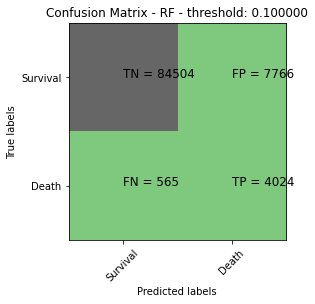

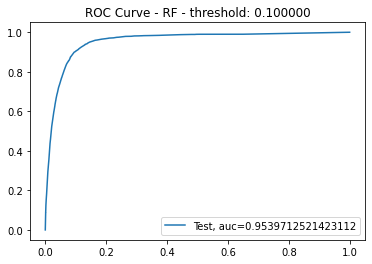

RF - threshold: 0.300000
--------------------------------------------------------------------------
accuracy score :0.9516720180881487
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     92270
           1       0.49      0.65      0.56      4589

    accuracy                           0.95     96859
   macro avg       0.74      0.81      0.77     96859
weighted avg       0.96      0.95      0.95     96859



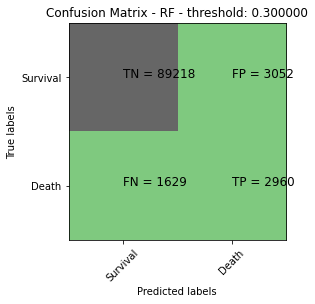

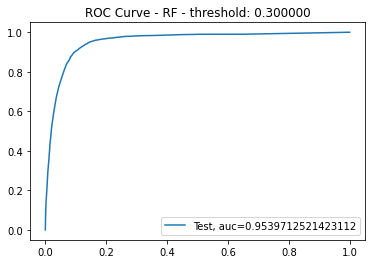

RF - threshold: 0.500000
--------------------------------------------------------------------------
accuracy score :0.9582898852971846
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     92270
           1       0.60      0.35      0.44      4589

    accuracy                           0.96     96859
   macro avg       0.79      0.67      0.71     96859
weighted avg       0.95      0.96      0.95     96859



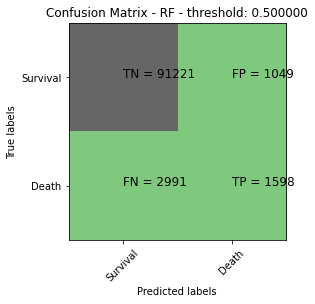

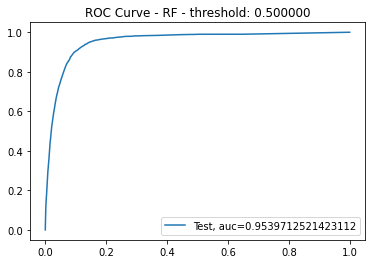

RF - threshold: 0.700000
--------------------------------------------------------------------------
accuracy score :0.9565141081365697
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     92270
           1       0.76      0.12      0.21      4589

    accuracy                           0.96     96859
   macro avg       0.86      0.56      0.59     96859
weighted avg       0.95      0.96      0.94     96859



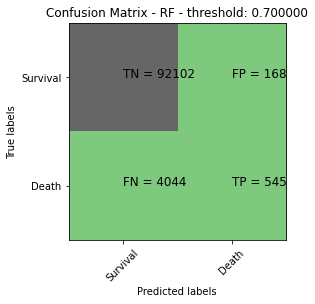

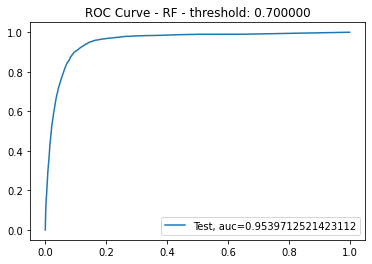

RF - threshold: 0.900000
--------------------------------------------------------------------------
accuracy score :0.95300385095861
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     92270
           1       0.82      0.01      0.02      4589

    accuracy                           0.95     96859
   macro avg       0.89      0.51      0.50     96859
weighted avg       0.95      0.95      0.93     96859



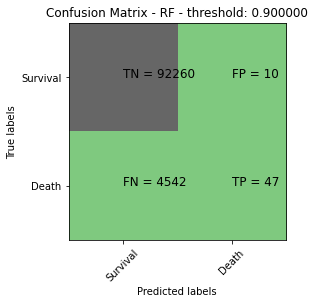

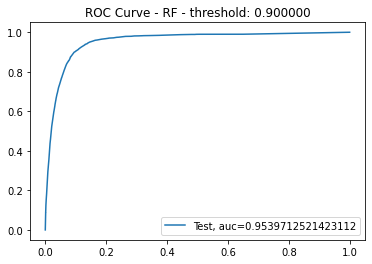

In [ ]:
for i in np.arange(0.1,1,0.2):
  performRfUsingThreshold(i)